In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import regularAtlmask

In [1]:
datafolder = ''

In [3]:
experiment = 'E280' 
model = 'GISS2.1G'
folder = datafolder+'Raw_data/'+model+'/'

In [8]:
dsV = xr.open_dataset(folder+experiment+'/vo_100yr.nc',decode_times=False)
dsT = xr.open_dataset(folder+experiment+'/thetao_100yr.nc',decode_times=False)
dsS = xr.open_dataset(folder+experiment+'/so_100yr.nc',decode_times=False)
dsOHT = xr.open_dataset(folder+experiment+'/hfbasin_annual_100yr.nc',decode_times=False)
dsov = xr.open_dataset(folder+experiment+'/htovovrt_annual_100yr.nc',decode_times=False)
dsgyre = xr.open_dataset(folder+experiment+'/htovgyre_annual_100yr.nc',decode_times=False)

if experiment == 'E280':
    dsr = xr.open_dataset(folder+experiment+'/KB288X180.modelE.BS1.nc',decode_times=False)
    dsice1 = xr.open_dataset(folder+experiment+'/siconca_SImon_GISS-E2-1-G_piControl_r1i1p1f1_gn_490101-495012.nc',decode_times=False)
    dsice2 = xr.open_dataset(folder+experiment+'/siconca_SImon_GISS-E2-1-G_piControl_r1i1p1f1_gn_495101-500012.nc',decode_times=False)
else:
    dsr = xr.open_dataset(folder+experiment+'/KB288x180_PlioceneII_EstB.nc',decode_times=False)
    dsice1 = xr.open_dataset(folder+experiment+'/siconca_SImon_GISS-E2-1-G_midPliocene-eoi400_r1i1p1f1_gn_305101-310012.nc',decode_times=False)
    dsice2 = xr.open_dataset(folder+experiment+'/siconca_SImon_GISS-E2-1-G_midPliocene-eoi400_r1i1p1f1_gn_310101-315012.nc',decode_times=False)
    
#Copy Atlantic mask for lon notation to match the T grid
dsr = dsr.assign_coords(lon=((360 + (dsr['lono'] % 360)) % 360)).sortby('lon')
ds = xr.Dataset(data_vars = dict(Atl=(("lat", "lon"), dsr.mask_atl.values)), coords = dict(lat = dsT.lat.values, lon = dsr.lon.values))
dsr = ds.copy(deep=True)

#Merge ice datasets for one 100-year dataset
dsice = xr.merge([dsice1, dsice2])

## Separation MOC and gyre OHT component 100-yr average

In [9]:
vvel = dsV.vo*100 #vvel in cm/s
temp = dsT.thetao #temp in degC

region = dsr.Atl

In [10]:
ds = dsT.copy(deep=True)

#1-D spacing z-direction centered at midpoints where V and T are defined
dz = np.zeros(len(ds.lev))
dz[0] = ds.lev[0].values*2
depth = dz[0]
for i in range(1,len(ds.lev)):
    dz[i] = (ds.lev[i].values-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
ds['dz'] = xr.DataArray(data=dz, dims=("lev"))
dz = ds.dz

#2-D array spacing x-direction centered at T gridpoints
r = 6.37122e8 #radius Earth in cm
dlon = np.deg2rad((ds.lon[2]-ds.lon[1]))*r*np.cos(np.deg2rad(ds.lat)) #Lon spacing. Units: cm

a = dlon
dlon = np.zeros([len(ds.lat),len(ds.lon)])
for i in range(len(ds.lon)):
    dlon[:,i]=a.values
ds['dlon']=xr.DataArray(data = dlon, dims=("lat","lon"))
dlon = ds.dlon

In [11]:
cp_sw = 3996.  # [J/(kg degC)]   heat capacity of water
rho_sw = 1.026e-3  # [kg/cm^3]  density of water

HEAT = (cp_sw*rho_sw*temp).where(region>0)  #  [J/(kg K) * kg/cm^3 * degC] = [J/cm]

vvel = vvel.fillna(0).interp(lat = dsT.lat, lon = dsT.lon, method='linear')
vvel = vvel.where(region>0) #cm/s
VVEL = vvel*HEAT/HEAT #Mask land with NaN values of the T grid

In [12]:
#Zonal mean velocity and heat
VVEL_zm = VVEL.mean(dim='lon')
HEAT_zm = HEAT.mean(dim='lon')

#Make zonal mean fields into 3D fields again
HEAT_zm_3D = HEAT/HEAT
HEAT_zm_3D = HEAT_zm_3D*HEAT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components
HEAT_prime = (HEAT - HEAT_zm) # azonal heat component (x,y,z) [J/cm]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

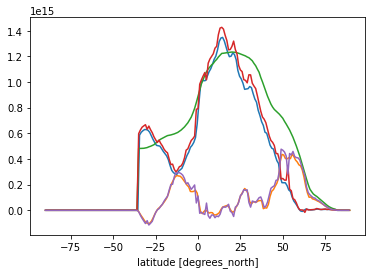

In [13]:
#Integrate to compute OHTov and OHTaz
Hov = (VVEL_zm_3D*HEAT_zm_3D*dlon*dz).sum(dim=['lon','lev'])
Haz = (VVEL_prime*HEAT_prime*dlon*dz).sum(dim=['lon','lev'])  # product of primed velocity and heat [cm/s * J/cm^2 * cm]

Hov.plot()
Haz.plot()
plt.plot(dsOHT.lat, dsOHT.hfbasin[:,0,:].mean(dim='year'))
plt.plot(dsov.lat, dsov.htovovrt[:,0,:].mean(dim='year'))
plt.plot(dsgyre.lat, dsgyre.htovgyre[:,0,:].mean(dim='year'))
plt.show()

In [14]:
dsE = xr.Dataset(data_vars = dict(OHTov=(["lat"], Hov/1e15), OHTaz=(["lat"], Haz/1e15)), coords = dict(lat = dsT.lat.values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomOHT_100yr.nc')

## 100-yr AMOC calculation using velocity fields

In [15]:
region = dsr.Atl.interp(lat = dsV.lat, method = 'linear') #Interpolate region file to V grid

vvel = dsV.vo*100 #vvel in cm/s
vvel = vvel.where(region>0).fillna(0) #Select only Atlantic and fill any NaN with 0 in velocity field

ds = dsV.copy(deep=True)

#1-D spacing z-direction centered at midpoints where V and T are defined
dz = np.zeros(len(ds.lev))
dz[0] = ds.lev[0].values*2
depth = dz[0]
for i in range(1,len(ds.lev)):
    dz[i] = (ds.lev[i].values-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
ds['dz'] = xr.DataArray(data=dz, dims=("lev"))
dz = ds.dz

#2-D array spacing x-direction centered at V gridpoints
r = 6.37122e8 #radius Earth in cm
dlon = np.deg2rad((ds.lon[2]-ds.lon[1]))*r*np.cos(np.deg2rad(ds.lat)) #Lon spacing. Units: cm

a = dlon
dlon = np.zeros([len(ds.lat),len(ds.lon)])
for i in range(len(ds.lon)):
    dlon[:,i]=a.values
ds['dlon']=xr.DataArray(data = dlon, dims=("lat","lon"))
dlon = ds.dlon

In [16]:
#Integrate velocity over basin
v_intx = (vvel*dlon).sum(dim='lon')
DZ = ds.dz*v_intx/v_intx #Make DZ the same size array as zonally integrated velocity

#Fill any NaN with zeros
v_intx = v_intx.fillna(0)
DZ = DZ.fillna(0)

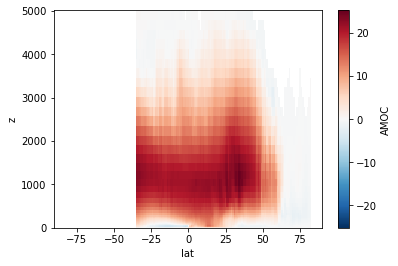

In [17]:
#Integrate over depth to create Atlantic meridional streamfunction
amoc = np.zeros([40,180])
for i in range(0,180):
    for j in range(0,40):
        if DZ[j,i] == 0:
            amoc[j,i] = np.nan
        else:
            amoc[j,i] = (v_intx[0:j+1,i]*DZ[0:j+1,i]).sum(dim='lev') #cm^3/s
amoc = amoc/1e12 #Sv

dsM = xr.Dataset(data_vars = dict(AMOC=(["z", "lat"], amoc)), coords = dict(z= dsV.lev.values, lat = dsV.lat.values))
dsM.AMOC.plot()
xr.Dataset.to_netcdf(dsM, path = datafolder+'Processed/'+model+'/'+experiment+'/AMOC_100yr.nc')

## Time series AMOC calculation using velocity fields (annual AMOC streamfunction)

In [18]:
#Same method as 100-year mean but now with annual velocity fields

dsV = xr.open_dataset(folder+experiment+'/vo_annual_100yr.nc',decode_times=False)
region = dsr.Atl.interp(lat = dsV.lat, method = 'linear')

vvel = dsV.vo*100 #vvel in cm/s
vvel = vvel.where(region>0).fillna(0)

ds = dsV.copy(deep=True)

#1-D spacing z-direction centered at midpoints where V and T are defined
dz = np.zeros(len(ds.lev))
dz[0] = ds.lev[0].values*2
depth = dz[0]
for i in range(1,len(ds.lev)):
    dz[i] = (ds.lev[i].values-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
ds['dz'] = xr.DataArray(data=dz, dims=("lev"))
dz = ds.dz

#2-D array spacing x-direction centered at V grid midpoints
r = 6.37122e8 #radius Earth in cm
dlon = np.deg2rad((ds.lon[2]-ds.lon[1]))*r*np.cos(np.deg2rad(ds.lat)) #Lon spacing. Units: cm

a = dlon
dlon = np.zeros([len(ds.lat),len(ds.lon)])
for i in range(len(ds.lon)):
    dlon[:,i]=a.values
ds['dlon']=xr.DataArray(data = dlon, dims=("lat","lon"))
dlon = ds.dlon

In [40]:
#Integrate velocity over basin
v_intx = (vvel*dlon).sum(dim='lon')
DZ = ds.dz*v_intx[0]/v_intx[0]

#Fill any NaN with zeros
v_intx = v_intx.fillna(0)
DZ = DZ.fillna(0)

In [41]:
#Integrate over depth to create Atlantic meridional streamfunction for every timestep
amoc = np.zeros([100,40,180])
for k in range(0,100):
    for i in range(0,180):
        for j in range(0,40):
            if DZ[j,i] == 0:
                amoc[k,j,i] = np.nan
            else:
                amoc[k,j,i] = (v_intx[k,0:j+1,i]*DZ[0:j+1,i]).sum(dim='lev') #cm^3/s
amoc = amoc/1e12 #Sv

if experiment == 'E280':
    dsM2 = xr.Dataset(data_vars = dict(AMOC=(["time","z", "lat"], amoc)), coords = dict(time = np.arange(4901,5001), z = dsV.lev.values, lat = dsV.lat.values))
elif experiment =='Eoi400':
    dsM2 = xr.Dataset(data_vars = dict(AMOC=(["time","z", "lat"], amoc)), coords = dict(time = np.arange(3051,3151), z = dsV.lev.values, lat = dsV.lat.values))
xr.Dataset.to_netcdf(dsM2, path = datafolder+'Processed/'+model+'/'+experiment+'/AMOC_annual_100yr.nc')

## 100-yr average Atlantic OHT

In [19]:
dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), (dsOHT.hfbasin[:,0,:].mean(dim='year')/1e15).values)), coords = dict(lat = dsOHT.lat.values))
xr.Dataset.to_netcdf(dsH, path = datafolder+'Processed/'+model+'/'+experiment+'/OHT_100yr.nc')

## Annual SST timeseries (100 years)

In [21]:
dstos = xr.open_dataset(folder+experiment+'/GISS2.1G_'+experiment+'.SST.timeseries_no_ann_cycle.nc')#, decode_times=False)
dsclim = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc')

tosann = dstos.tos.groupby('time.year').mean(dim='time')+dsclim.tos.mean(dim='month')

dsSST = xr.Dataset(data_vars = dict(sst=(("time","lat","lon"), tosann.values)), coords = dict(time = tosann.year.values, lat = tosann.latitude.values, lon = tosann.longitude.values))
xr.Dataset.to_netcdf(dsSST, path = datafolder+'Processed/'+model+'/'+experiment+'/SST_annual_100yr.nc')

## 100-yr mean SSS (regridded)

In [22]:
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc')
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

sss = regridder(dsS.so[0])

dsSSS = xr.Dataset(data_vars = dict(sss=(("lat","lon"), sss)), coords = dict(lat = sss.latitude.values, lon = sss.longitude.values))
xr.Dataset.to_netcdf(dsSSS, path = datafolder+'Processed/'+model+'/'+experiment+'/SSS_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean sea-ice (regridded)

In [23]:
dsi = dsice.drop('time')

djf = (dsi.siconca[11:1200:12]+dsi.siconca[0:1200:12]+dsi.siconca[1:1200:12])/3
djf = djf.mean(dim='time')

mam = (dsi.siconca[2:1200:12]+dsi.siconca[3:1200:12]+dsi.siconca[4:1200:12])/3
mam = mam.mean(dim='time')

jja = (dsi.siconca[5:1200:12]+dsi.siconca[6:1200:12]+dsi.siconca[7:1200:12])/3
jja = jja.mean(dim='time')

son = (dsi.siconca[8:1200:12]+dsi.siconca[9:1200:12]+dsi.siconca[10:1200:12])/3
son = son.mean(dim='time')

dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc')
regridder = xe.Regridder(dsi, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

si_djf = regridder(djf)*sss/sss #Use grid from SSS to mark continents
si_mam = regridder(mam)*sss/sss
si_jja = regridder(jja)*sss/sss
si_son = regridder(son)*sss/sss

si = (si_djf+si_mam+si_jja+si_son)/4

dsSI = xr.Dataset(data_vars = dict(si_djf=(("lat","lon"), si_djf), si_mam = (("lat","lon"), si_mam), si_jja = (("lat","lon"), si_jja), si_son = (("lat","lon"), si_son), si_mean = (("lat","lon"), si)), coords = dict(lat = si_djf.latitude.values, lon = si_djf.longitude.values))
xr.Dataset.to_netcdf(dsSI, path = datafolder+'Processed/'+model+'/'+experiment+'/SI_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.a

## 100-yr mean top 100 m salinity

In [24]:
def makedz(z):
    dz = np.zeros(len(z))
    dz[0] = z[0].values*2
    depth = dz[0]
    for i in range(1,len(z)):
        dz[i] = (z[i]-depth)*2
        depth = depth+dz[i] #Depth spacing. Units: cm
    return xr.DataArray(data=dz, dims=("lev"))

regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
weights = makedz(dsS.lev[0:6])

s100m = regridder(dsS.so[0:6].weighted(weights).mean(dim='lev'))

dsS100m = xr.Dataset(data_vars = dict(s100m=(("lat","lon"), s100m)), coords = dict(lat = s100m.latitude.values, lon = s100m.longitude.values))
xr.Dataset.to_netcdf(dsS100m, path = datafolder+'Processed/'+model+'/'+experiment+'/so100m_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr zonal mean salinity

In [25]:
salt_atl = dsS.so

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc')
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

salt = regridder(salt_atl)
mask = regularAtlmask(salt)

salt_zm = salt.where(mask>-1).mean(dim='longitude')

dszm = xr.Dataset(data_vars = dict(so=(("z","lat"), salt_zm)), coords = dict(z = salt_zm.lev.values, lat = salt_zm.latitude.values))
xr.Dataset.to_netcdf(dszm, path = datafolder+'Processed/'+model+'/'+experiment+'/so_zm_100yr.nc')

## 100-yr zonal mean temperature

In [26]:
temp_atl = dsT.thetao

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc')
regridder = xe.Regridder(dsT, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

temp = regridder(temp_atl)
mask = regularAtlmask(temp)

temp_zm = temp.where(mask>-1).mean(dim='longitude')

dtzm = xr.Dataset(data_vars = dict(thetao=(("z","lat"), temp_zm)), coords = dict(z = temp_zm.lev.values, lat = temp_zm.latitude.values))
xr.Dataset.to_netcdf(dtzm, path = datafolder+'Processed/'+model+'/'+experiment+'/thetao_zm_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean wind at 1000 hPa

In [27]:
if experiment == 'E280':
    dsu1= xr.open_dataset(folder+experiment+'/Atm/ua_Amon_GISS-E2-1-G_piControl_r1i1p1f1_gn_490101-495012.nc',decode_times=False)
    dsu2 = xr.open_dataset(folder+experiment+'/Atm/ua_Amon_GISS-E2-1-G_piControl_r1i1p1f1_gn_495101-500012.nc',decode_times=False)
    dsu = xr.merge([dsu1, dsu2])
    dsv1= xr.open_dataset(folder+experiment+'/Atm/va_Amon_GISS-E2-1-G_piControl_r1i1p1f1_gn_490101-495012.nc',decode_times=False)
    dsv2 = xr.open_dataset(folder+experiment+'/Atm/va_Amon_GISS-E2-1-G_piControl_r1i1p1f1_gn_495101-500012.nc',decode_times=False)
    dsv = xr.merge([dsv1, dsv2])
else:
    dsu1= xr.open_dataset(folder+experiment+'/Atm/ua_Amon_GISS-E2-1-G_midPliocene-eoi400_r1i1p1f1_gn_305101-310012.nc',decode_times=False)
    dsu2 = xr.open_dataset(folder+experiment+'/Atm/ua_Amon_GISS-E2-1-G_midPliocene-eoi400_r1i1p1f1_gn_310101-315012.nc',decode_times=False)
    dsu = xr.merge([dsu1, dsu2])
    dsv1= xr.open_dataset(folder+experiment+'/Atm/va_Amon_GISS-E2-1-G_midPliocene-eoi400_r1i1p1f1_gn_305101-310012.nc',decode_times=False)
    dsv2 = xr.open_dataset(folder+experiment+'/Atm/va_Amon_GISS-E2-1-G_midPliocene-eoi400_r1i1p1f1_gn_310101-315012.nc',decode_times=False)
    dsv = xr.merge([dsv1, dsv2])

In [28]:
ua = dsu.ua[:,0].mean(dim='time')
va = dsv.va[:,0].mean(dim='time')

In [29]:
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc')
regridder = xe.Regridder(dsu, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

u = regridder(ua)
v = regridder(va)

dsUV = xr.Dataset(data_vars = dict(ua=(("lat","lon"), u), va=(("lat","lon"), v)), coords = dict(lat = u.latitude.values, lon = v.longitude.values))
xr.Dataset.to_netcdf(dsUV, path = datafolder+'Processed/'+model+'/'+experiment+'/UVa_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
